In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)

In [ ]:
# read in training file 
# training_data = pd.read_csv('../Data/hip_fracture_training.csv')
training_data = pd.read_csv('hip_fracture_training.csv')


In [ ]:
def filter_data(df, preop_cols): 

    # filters for only the preoperative columns
    df_preop = df[preop_cols]

    return df_preop    

In [34]:
peri_cols = [
    'TransferStatus_17', 'TransferStatus_18', 'TransferStatus_19', 'TransferStatus_20',
    'DispoLocationPost_21', 'DispoLocationPost_22', 'DispoLocationPost_23', 'DispoLocationPost_24',
    'DispoLocationPost_25', 'DispoLocationPost_26', 'DispoLocationPost_27', 'DispoLocationPost_28',
    'DispoLocationPost_29', 'DispoLocationPost_30', 'DispoLocationPost_31', 'DispoLocationPost_32',
    'MEDMGMT_13', 'MEDMGMT_14', 'MEDMGMT_15', 'StandardHip_17', 'HipFractureType_44',
    'HipFractureType_45', 'HipFractureType_46', 'HipFractureType_47', 'HipFractureType_48',
    'PathologicHipFractures_49', 'PathologicHipFractures_50', 'PathologicHipFractures_51',
    'DischargeNotHome', 'READMISSION30D'
]
peri_df = filter_data(training_data, peri_cols)

print(peri_df.shape)

print(peri_df.TransferStatus_20.dtype)

(29188, 30)
int64


In [36]:
# next we need to remove unknowns
unknwon_cols = ['TransferStatus_20', 'DispoLocationPost_31']

cleaned_df = peri_df[(peri_df['TransferStatus_20'] != 1) & (peri_df['DispoLocationPost_31'] != 1)]

# remove columns with only one unique value (does not add info)
for col in cleaned_df.columns:
    if len(cleaned_df[col].unique()) == 1:
        cleaned_df.drop(col,inplace=True,axis=1)

print(cleaned_df.shape)

(29155, 27)


<ipython-input-36-6a53de2183ea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(col,inplace=True,axis=1)
<ipython-input-36-6a53de2183ea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(col,inplace=True,axis=1)
<ipython-input-36-6a53de2183ea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(col,inplace=True,axis=1)


In [37]:
def split_data(df): 
    X = df.drop(labels = ['READMISSION30D'], axis = 1) 
    y = pd.DataFrame(df['READMISSION30D']) 
    X_train,X_test,y_train,y_test = train_test_split(X, y, stratify = y, test_size= .2, random_state= 0 )
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = split_data(cleaned_df)
display(X_train.info()) 
display(X_test.info())
display(y_train.info())
display(y_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23324 entries, 25505 to 26805
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   TransferStatus_17          23324 non-null  int64
 1   TransferStatus_18          23324 non-null  int64
 2   TransferStatus_19          23324 non-null  int64
 3   DispoLocationPost_21       23324 non-null  int64
 4   DispoLocationPost_22       23324 non-null  int64
 5   DispoLocationPost_23       23324 non-null  int64
 6   DispoLocationPost_24       23324 non-null  int64
 7   DispoLocationPost_25       23324 non-null  int64
 8   DispoLocationPost_26       23324 non-null  int64
 9   DispoLocationPost_28       23324 non-null  int64
 10  DispoLocationPost_29       23324 non-null  int64
 11  DispoLocationPost_30       23324 non-null  int64
 12  DispoLocationPost_32       23324 non-null  int64
 13  MEDMGMT_13                 23324 non-null  int64
 14  MEDMGMT_14        

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5831 entries, 23776 to 16393
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   TransferStatus_17          5831 non-null   int64
 1   TransferStatus_18          5831 non-null   int64
 2   TransferStatus_19          5831 non-null   int64
 3   DispoLocationPost_21       5831 non-null   int64
 4   DispoLocationPost_22       5831 non-null   int64
 5   DispoLocationPost_23       5831 non-null   int64
 6   DispoLocationPost_24       5831 non-null   int64
 7   DispoLocationPost_25       5831 non-null   int64
 8   DispoLocationPost_26       5831 non-null   int64
 9   DispoLocationPost_28       5831 non-null   int64
 10  DispoLocationPost_29       5831 non-null   int64
 11  DispoLocationPost_30       5831 non-null   int64
 12  DispoLocationPost_32       5831 non-null   int64
 13  MEDMGMT_13                 5831 non-null   int64
 14  MEDMGMT_14         

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23324 entries, 25505 to 26805
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   READMISSION30D  23324 non-null  int64
dtypes: int64(1)
memory usage: 364.4 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5831 entries, 23776 to 16393
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   READMISSION30D  5831 non-null   int64
dtypes: int64(1)
memory usage: 91.1 KB


None

In [38]:
def rf_feature_importance(X_train,X_test,y_train): 

    #we will start off using the default scikit learn features 
    rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=5,n_estimators=1000,
                                 max_features=0.1,max_samples=0.7,random_state=0)
     #Fit the tree to the data
    rf_model.fit(X_train, y_train)

    #predict on the validation set
    preds = rf_model.predict(X_test)

    #define feature names 
    feat_names = X_train.columns 

    #define the number of features to show
    num_to_show = 55 

    # Determine the relative importance of each feature using the random forest model
    importances = rf_model.feature_importances_

    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:30][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()

    return RF_ranking, rf_model, preds

<ipython-input-38-220ee39987aa>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


,Feat Index,Feature,Importance
0,16,StandardHip_17,0.110977
1,4,DispoLocationPost_22,0.088902
2,1,TransferStatus_18,0.066545
3,11,DispoLocationPost_30,0.057158
4,0,TransferStatus_17,0.054766
5,19,HipFractureType_46,0.048036
6,17,HipFractureType_44,0.046280
7,18,HipFractureType_45,0.045561
8,14,MEDMGMT_14,0.043094
9,6,DispoLocationPost_24,0.042558


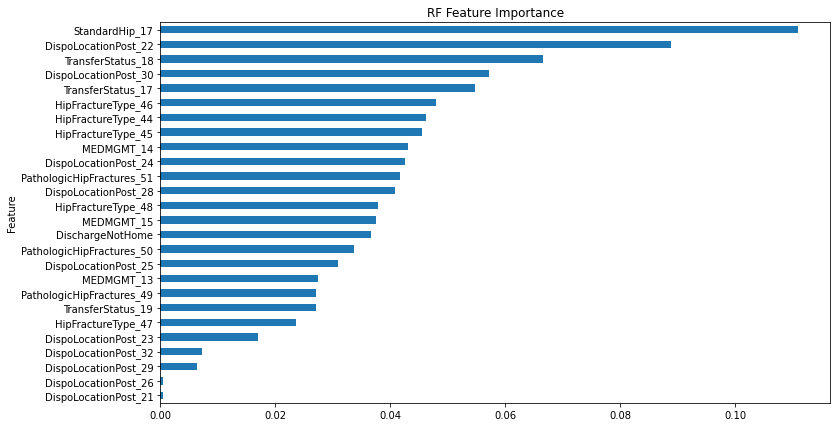

In [39]:
RF_ranking, rf_model, preds = rf_feature_importance(X_train,X_test,y_train)


In [ ]:
print(f'the results for {rf_model}' + classification_report(y_test, preds))
plot_roc_curve(rf_model,X_test,y_test)
# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.show()